In [38]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import rfft, fftfreq
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

file_path = r'C:\Users\micha\Downloads\train_dataset_1\a000_1\data.hdf5'

Idea: When clustering we are looking to target relevant behaviour. If naive and applied to the whole data set, emergent groups would correspond to behaviour on the choosen time scale. For dt=0.05 this could be swinging the IMU left or right, or changing orientation. But as we are interested in behaviour on the seconds scale, like walking or sitting or talking on the phone, a relevant "time binning" must be applied. 

In [39]:
if '..' not in sys.path:
    sys.path.append('../')
from utils import load_data
data_dict = load_data(file_path, verbose=False)

N = 67_000 #Chopped to fit time bins
time_bin_size = 1000 #5 seconds pr behavior bin
num_bins = int(N/time_bin_size) #Giving 67 time bins

if N == 0:
    ekf_ori = data_dict['pose/ekf_ori']
    tango_ori = data_dict['pose/tango_ori']
    tango_pos = data_dict['pose/tango_pos']
    gyro = data_dict['synced/gyro']
    gyro_uncalib = data_dict['synced/gyro_uncalib']
    acc = data_dict['synced/acce']
    linacc = data_dict['synced/linacce']
    mag = data_dict['synced/magnet']
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time']
    rv = data_dict['synced/rv']
    game_rv = data_dict['synced/game_rv']
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]
    
else:
    ekf_ori = data_dict['pose/ekf_ori'][:N]
    tango_ori = data_dict['pose/tango_ori'][:N]
    tango_pos = data_dict['pose/tango_pos'][:N]
    gyro = data_dict['synced/gyro'][:N]
    gyro_uncalib = data_dict['synced/gyro_uncalib'][:N]
    acc = data_dict['synced/acce'][:N]
    linacc = data_dict['synced/linacce'][:N]
    mag = data_dict['synced/magnet'][:N]
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time'][:N]
    rv = data_dict['synced/rv'][:N]
    game_rv = data_dict['synced/game_rv'][:N]
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]

selected_features = np.concatenate([ekf_ori.T, acc.T]).T #For now I only work with orientation and acceleration

print(ekf_ori.shape,acc.shape)

data_unprocessed = np.zeros((selected_features.shape[1], num_bins, time_bin_size))

#print(selected_features[j*time_bin_size : (j+1)*time_bin_size ].shape, i)

for i in range(selected_features.shape[1]):
    for j in range(num_bins):
        data_unprocessed[i,j,:] = selected_features[j*time_bin_size : (j+1)*time_bin_size, i]

#print(data_unprocessed.shape)

(67000, 4) (67000, 3)


Additionally a guiding hand in extracting the relevent features from the data should be applied. Characteristics of behaviour could be the average, the std and FFT of the orientation and acceration in the time bin.

In [40]:
data_average = np.mean(data_unprocessed, axis=2)
data_std = np.std(data_unprocessed, axis=2)
data_signal = (data_unprocessed - data_average[:,:,None])/data_std[:,:,None]
data_fft = rfft(data_signal, axis=2)
print(data_fft.shape)

(7, 67, 501)


Text(0.5, 1.0, 'FFT Acceleration')

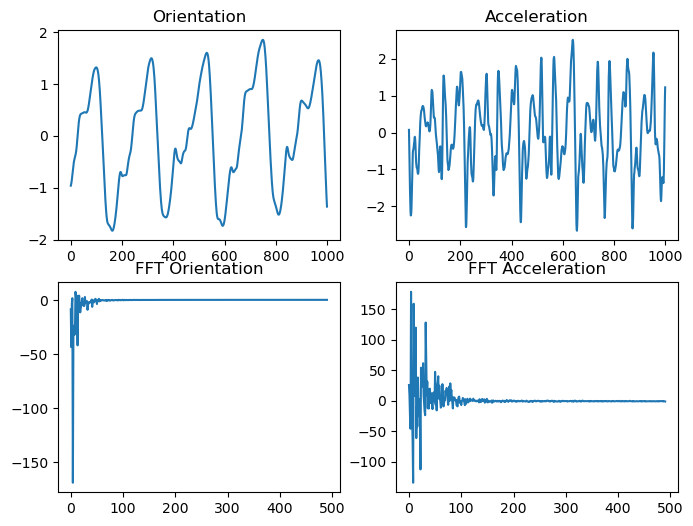

In [41]:
#Plotting the signal and FFT for the a specific time bin
time_bin_number = 15
fig1, axs = plt.subplots(2, 2, figsize=(8,6))
axs[0, 0].plot(data_signal[0,time_bin_number,:])
axs[0, 0].set_title('Orientation')
axs[0, 1].plot(data_signal[4,time_bin_number,:])
axs[0, 1].set_title('Acceleration')
axs[1, 0].plot(data_fft[0,time_bin_number,10:])
axs[1, 0].set_title('FFT Orientation')
axs[1, 1].plot(data_fft[4,time_bin_number,10:])
axs[1, 1].set_title('FFT Acceleration')

Next up is to concatenate the data, inspect it and set it up for clustering.

(7, 67) (7, 67)


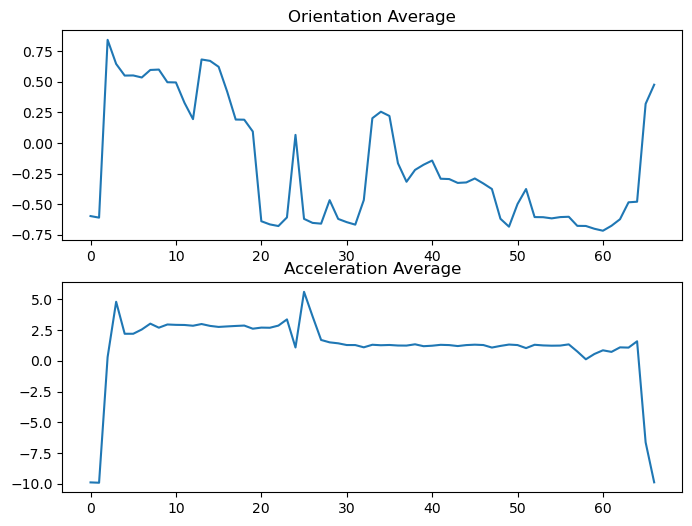

In [42]:
# Concatenate and inspect the data
print(data_average.shape, data_std.shape)
data_processed = np.concatenate([data_average, data_std]).T #Missing the FFT components for now

fig2, axs =plt.subplots(2,1,figsize=(8,6))
axs[0].plot(data_processed[:,0])
axs[0].set_title('Orientation Average')
axs[1].plot(data_processed[:,4])
axs[1].set_title('Acceleration Average')
plt.show()

Then apply various clustering methods for comparison

In [43]:
# Apply K-means clustering
num_cluster = 3

kmeans = KMeans(n_clusters=num_cluster)
kmeans_labels = kmeans.fit_predict(data_processed)
print(kmeans_labels)
# Apply Agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=num_cluster)
agglomerative_labels = agglomerative.fit_predict(data_processed)
print(agglomerative_labels)

c:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2]
[2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2]


For visualizing I extract the labels and apply them to the tango_pos and then plot them accordingly (Only x and y dimensions)

blue


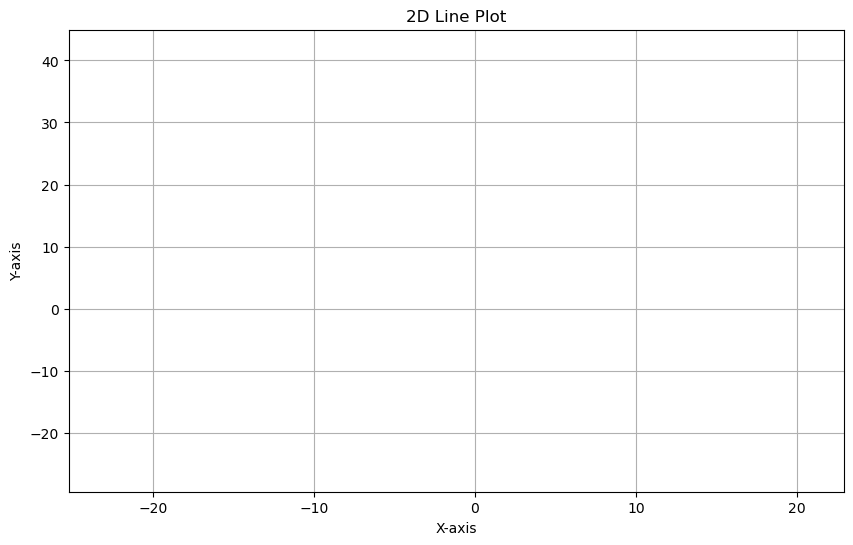

In [48]:
# Create a 2D line plot

label_agglo = np.repeat(agglomerative_labels, time_bin_size)
label_kmeans = np.repeat(kmeans_labels, time_bin_size)
color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow', 4: 'orange', 5: 'purple', 6: 'pink', 7: 'brown', 8: 'gray', 9: 'cyan'}
colors_agglo = [color_map[label] for label in label_agglo]
colors_kmeans = [color_map[label] for label in label_kmeans]

plt.figure(figsize=(10, 6))

print(colors_agglo[1231])



# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Line Plot')
plt.grid(True)  # Add gridlines

# Show the plot
plt.show()